In [1]:
import numpy as np

import ND_path_finder.src.path_finders.voronoi as VOR

from ND_path_finder.src.data_generators.perlin_generator import PerlinNoiseGenerator
from ND_path_finder.src.data_samplers.random_sampler import sample_xarray
from ND_path_finder.src.edge_detection.SVM_2D_contour import svm_boundary_2D

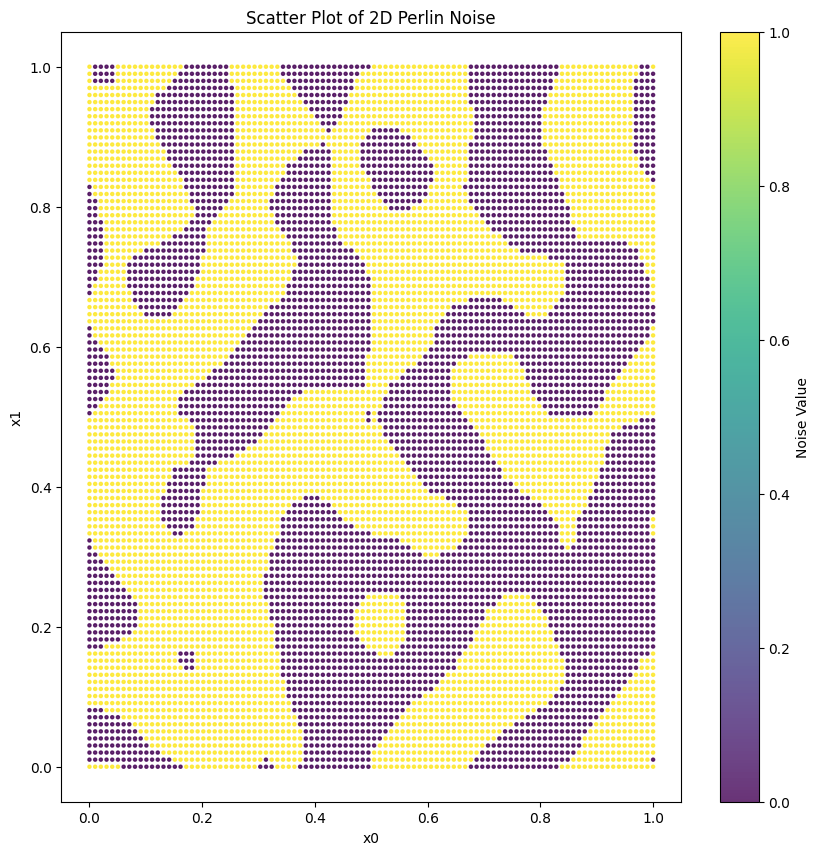

In [71]:
generator_2D = PerlinNoiseGenerator(res=[100, 100], octv=6, seed=42, time_test=False)

xdataset_2D = generator_2D.perlin_data_xarray()

generator_2D.plot_2D_xarray()


Best parameters: {'C': 5, 'gamma': 100}


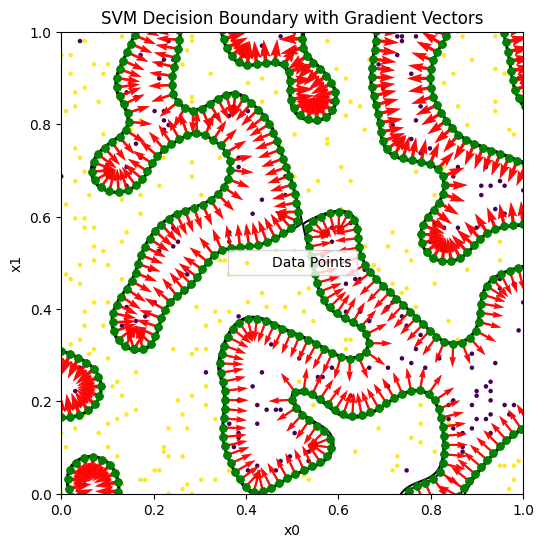

In [72]:

boundary_points, gradients = svm_boundary_2D(sample_xarray(xdataset_2D, 400), boundary_resolution_len=0.02, plot=True)

In [73]:


combined_boundary_points = np.vstack([np.vstack(segment) for segment in boundary_points])
combined_gradients = np.vstack([np.vstack(grad) for grad in gradients])

print(combined_boundary_points.shape)  # Check the shape of the combined array

(1030, 2)


In [74]:
combined_gradients.shape

(1030, 2)

In [75]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d



def voronoi_points(coord_array, gradients, plot=False):

    # Compute Voronoi diagram
    vor = Voronoi(coord_array)

    
    
    if plot:
        # Plotting
        # plt.figure(figsize=(8, 6))
        fig, ax = plt.subplots(figsize=(8, 6))
        voronoi_plot_2d(vor, ax=ax, show_vertices=False)
        plt.quiver(
            coord_array[:, 0], coord_array[:, 1],
            gradients[:, 0]*.005, gradients[:, 1]*.005,
            angles='xy', scale_units='xy', scale=0.01, color='r', alpha=0.8, headwidth=3
        )
        # ax.plot(filtered_coord[:, 0], filtered_coord[:, 1], 'ko')
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        
        # Configure the plot
        plt.gca().set_aspect('equal', adjustable='box')

        plt.show()

    return vor


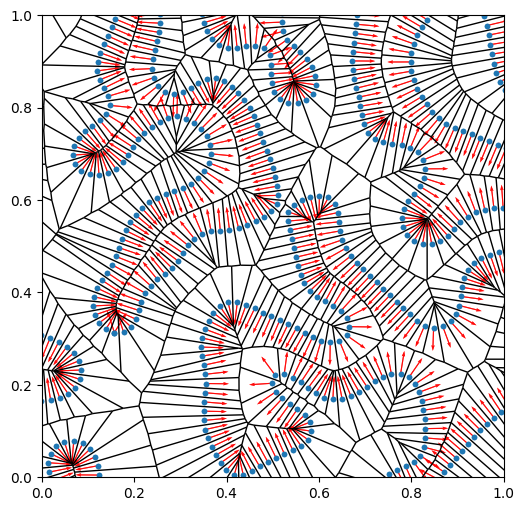

In [76]:
vor = voronoi_points(combined_boundary_points, combined_gradients, plot=True)

In [77]:
print(combined_gradients.shape)
print(vor.vertices.shape)

(1030, 2)
(998, 2)


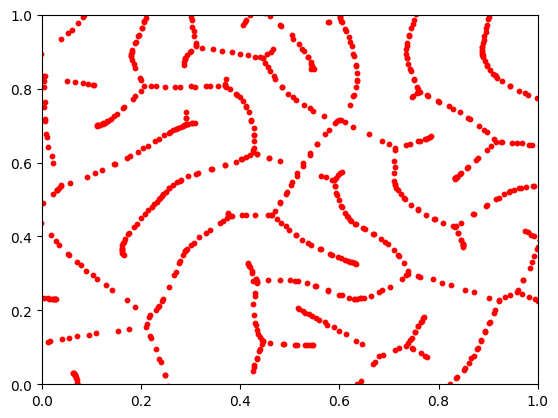

In [78]:
plt.scatter(vor.vertices[:, 0], vor.vertices[:, 1], c='r', s=10)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

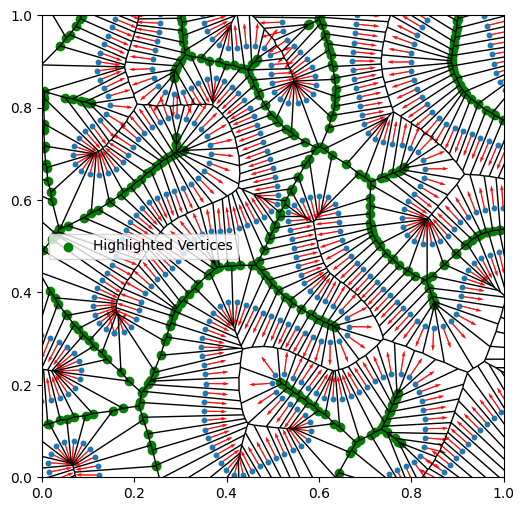

In [79]:
def compute_sink_vertices(coord_array, gradients, plot=False):
    from scipy.spatial import Voronoi, voronoi_plot_2d

    # Compute the Voronoi diagram
    vor = Voronoi(coord_array)

    # Initialize a set to store vertices to highlight
    highlight_vertices = set()

    # Loop through Voronoi vertices
    for vertex_idx, vertex in enumerate(vor.vertices):
        if np.any(vertex < 0) or np.any(vertex > 1):
            # Skip vertices outside the diagram bounds
            continue

        inward_count = 0
        outward_count = 0

        # Check all regions (sites) associated with the vertex
        for point_idx in range(len(vor.point_region)):
            # Get the region of the point
            region_idx = vor.point_region[point_idx]
            region = vor.regions[region_idx]

            # Skip regions with infinite vertices
            if -1 in region or vertex_idx not in region:
                continue

            # Compute vector from site to vertex
            site_to_vertex = vertex - coord_array[point_idx]

            # Check if gradient points "into" or "away" from the vertex
            if np.dot(gradients[point_idx], site_to_vertex) < 0:
                inward_count += 1  # Gradient points into the vertex
            else:
                outward_count += 1  # Gradient points away from the vertex

        # Retain vertex if all gradients point inward
        if outward_count == 0:
            highlight_vertices.add(vertex_idx)

    # Extract the coordinates of highlighted vertices
    highlighted_coords = vor.vertices[list(highlight_vertices)]

    # Plotting the results
    if plot:
        fig, ax = plt.subplots(figsize=(8, 6))
        voronoi_plot_2d(vor, ax=ax, show_vertices=False)
        plt.quiver(
            coord_array[:, 0], coord_array[:, 1],
            gradients[:, 0] * 0.005, gradients[:, 1] * 0.005,
            angles='xy', scale_units='xy', scale=0.01, color='r', alpha=0.8, headwidth=3
        )
        # Highlight vertices
        if len(highlighted_coords) > 0:
            plt.scatter(highlighted_coords[:, 0], highlighted_coords[:, 1], color='g', label='Highlighted Vertices')
        plt.legend()
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

    return highlighted_coords



# Example usage
sink_vertices = compute_sink_vertices(combined_boundary_points, combined_gradients, plot=True)
